In [1]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

from modules import solver, presolver
from pyballistics import ozvb_lagrange, get_db_powder, get_powder_names
from joblib import Parallel, delayed
from matplotlib import cm
from matplotlib.colors import ListedColormap


## Визуализация решения обратной задачи

In [ ]:
table_obr = pd.read_csv("data/table_result_lenght.csv")

## Прямая задача

In [8]:
table = pd.read_csv("data/direct_task.csv")

In [9]:
table[tabel['reason']=='x_p']['mass']

4       1183.937078
5       1069.465041
22       848.812171
26      1715.774297
28      4415.453580
           ...     
9984    1394.597251
9986    2437.948314
9988    1110.572261
9998    2344.278988
9999    2200.743336
Name: mass, Length: 2311, dtype: float64

In [10]:
Bluemap = cm.get_cmap('Blues', 1024)

newcolors = Bluemap(np.linspace(0, 1,1024))
newcolors[950:1024:, :] = cm.get_cmap('RdYlGn_r', 400)(np.linspace(0.0, 1, 74))[:74]
newcmpRdy = ListedColormap(newcolors[::-1])

C:\Users\Maksim\AppData\Local\Temp/ipykernel_11048/3072595002.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x = tabel[tabel['reason']=='x_p'][tabel['mass'] < treshold]['wq']
C:\Users\Maksim\AppData\Local\Temp/ipykernel_11048/3072595002.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y = tabel[tabel['reason']=='x_p'][tabel['mass'] < treshold]['ro']
C:\Users\Maksim\AppData\Local\Temp/ipykernel_11048/3072595002.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  col = tabel[tabel['reason']=='x_p'][tabel['mass'] < treshold]['mass']
C:\Users\Maksim\AppData\Local\Temp/ipykernel_11048/3072595002.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x1 = tabel[tabel['reason']=='x_p'][tabel['mass'] >= treshold]['wq']
C:\Users\Maksim\AppData\Local\Temp/ipykernel_11048/3072595002.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame inde

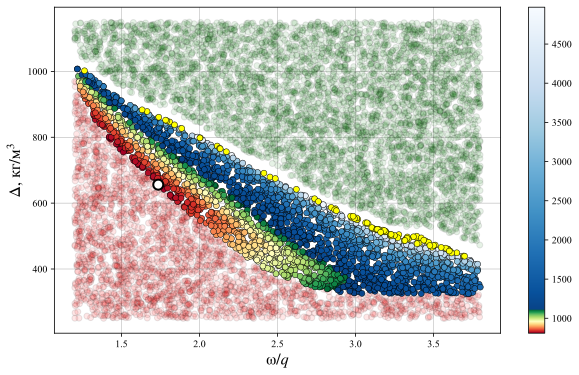

In [13]:
%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
fs = 16
fig = plt.figure(figsize=(10,6), dpi=300)

norm = mpl.colors.Normalize(vmin=500, vmax=4000)

treshold = 5000

x = tabel[tabel['reason']=='x_p'][tabel['mass'] < treshold]['wq']
y = tabel[tabel['reason']=='x_p'][tabel['mass'] < treshold]['ro']
col = tabel[tabel['reason']=='x_p'][tabel['mass'] < treshold]['mass']

x1 = tabel[tabel['reason']=='x_p'][tabel['mass'] >= treshold]['wq']
y1 = tabel[tabel['reason']=='x_p'][tabel['mass'] >= treshold]['ro']

plt.scatter(tabel[tabel['reason']=='v_p']['wq'], tabel[tabel['reason']=='v_p']['ro'],\
            color='red', edgecolors='black', linewidths=1, zorder = 3, alpha=0.1)
plt.scatter(tabel[tabel['reason']=='p_max']['wq'], tabel[tabel['reason']=='p_max']['ro'],\
            color='green', edgecolors='black', linewidths=1, zorder = 3, alpha=0.1)

fig3 = plt.scatter(x, y, c=col, cmap=newcmpRdy, edgecolors='black', linewidths=0.5, zorder = 3)
plt.scatter(x1, y1, c='yellow', edgecolors='black', linewidths=0.5, zorder = 3)

plt.scatter(wq_0, ro_0, color='white', edgecolors='black', s=100, linewidths=2, zorder = 3)

#plt.legend(fontsize=16, loc=(1.04,0.15) )
plt.colorbar(fig3)
plt.xlabel(r'$\mathrm{\omega/\mathit{q}}$',  fontsize = fs)
plt.ylabel('$\mathit{\Delta}$, $\mathrm{кг/м^3}$',  fontsize = fs)
plt.grid(linewidth=0.5)
plt.show()

In [ ]:
#fig.savefig('data/bananas.jpg', dpi = 400, pad_inches=10)

### Ствол

In [14]:
result = ozvb_lagrange(presolver.init_dict(name, wq_0, ro_0))

In [15]:
matrix_p = solver.Solver.make_matrix(result, 'p')
matrix_x = solver.Solver.make_matrix(result, 'x')

In [16]:
#add layre to 'p' for shape alignment with 'x'
matrix_p = np.row_stack((matrix_p.T, matrix_p.T[-1])).T
#calculate coordinate from 0 point
l0 = np.abs(matrix_x[0][0])
matrix_x += np.abs(matrix_x[0][0])

In [17]:
cannon = solver.Cannon(0.125, matrix_x, matrix_p, l0)

In [18]:
cannon.cannon_geometry()

#### Распределение давления

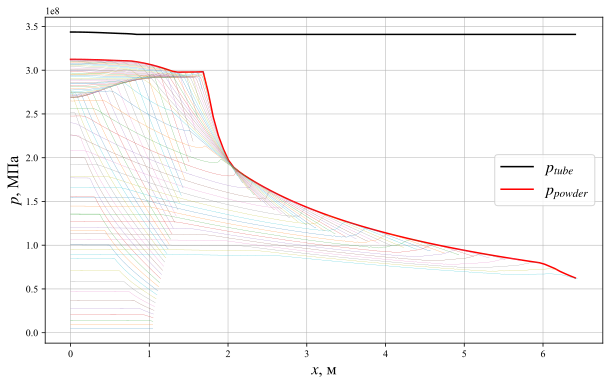

In [19]:
%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 
rc = {"font.family" : "serif",
        "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
#matplotlib.rcParams.update({'font.size': 17})
#plt.rcParams["font.family"] = "Times New Roman"

fs = 16
fig = plt.figure(figsize=(10,6), dpi=300)
plt.plot(cannon.coordinate, cannon.pressure_tube, color='black', label='$p_{tube}$')
plt.plot(cannon.coordinate, cannon.pressure, color='red', label='$p_{powder}$')

for i in range(0 ,matrix_p.shape[0], 20):
    plt.plot(matrix_x[i], matrix_p[i], linewidth=0.2)

plt.legend(fontsize=fs, loc = 'center right')
plt.xlabel(r'$x$, м',  fontsize=fs)
plt.ylabel(r'$p$, МПа',  fontsize=fs)
plt.grid(linewidth=0.5)
plt.show()

In [ ]:
fig.savefig('data/pressure.jpg', dpi = 400, pad_inches=10)

#### Геометрия

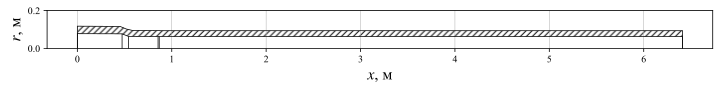

In [20]:
%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 

fs = 16
width = 0.75
fig = plt.figure(figsize=(12,0.7), dpi=300)
plt.plot(cannon.coordinate, cannon.r_outside, color='black', linewidth=width)
plt.plot(cannon.r_inside_coordinate, cannon.r_inside, color='black', linewidth=width)

for i in range(len(cannon.r_inside_coordinate)):
    plt.vlines(x=cannon.r_inside_coordinate[i], ymin=0, ymax=cannon.r_inside[i], color='black', linewidth=width)
    
plt.vlines(cannon.r_inside_coordinate[0], 0, cannon.r_outside[0], color='black', linewidth=width)
plt.vlines(cannon.r_inside_coordinate[-1], 0, cannon.r_outside[-1], color='black', linewidth=width)

plt.fill_between(cannon.coordinate, np.interp(cannon.coordinate, cannon.r_inside_coordinate, cannon.r_inside),
                 cannon.r_outside, facecolor="white", hatch="////")

plt.ylim(0, 0.2)
plt.xlabel(r'$x$, м',  fontsize=fs)
plt.ylabel(r'$r$, м',  fontsize=fs)
plt.grid(linewidth=0.5)
plt.show()

In [ ]:
fig.savefig('data/geometry.jpg', dpi = 400, pad_inches=10)

In [21]:
cannon.get_mass()

807.9710363918439